In [ ]:
import numpy as np

# Load training and validation data
train_data = np.load("../Data/npy/train.npy")
val_data = np.load("../Data/npy/val.npy")

# print(f"Train Data Shape: {train_data.shape}")
# print(f"Validation Data Shape: {val_data.shape}")

# # Inspect a few samples
# print(f"Sample Training Data: {train_data[:5]}")

import matplotlib.pyplot as plt

# Assume train_data[:, i] is the i-th numerical feature
for i in range(12):
    plt.hist(train_data[:, i], bins=20, alpha=0.5, label=f"Feature {i} (Train)")
    plt.hist(val_data[:, i], bins=20, alpha=0.5, label=f"Feature {i} (Validation)")
    plt.title(f"Feature {i} Distribution")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()



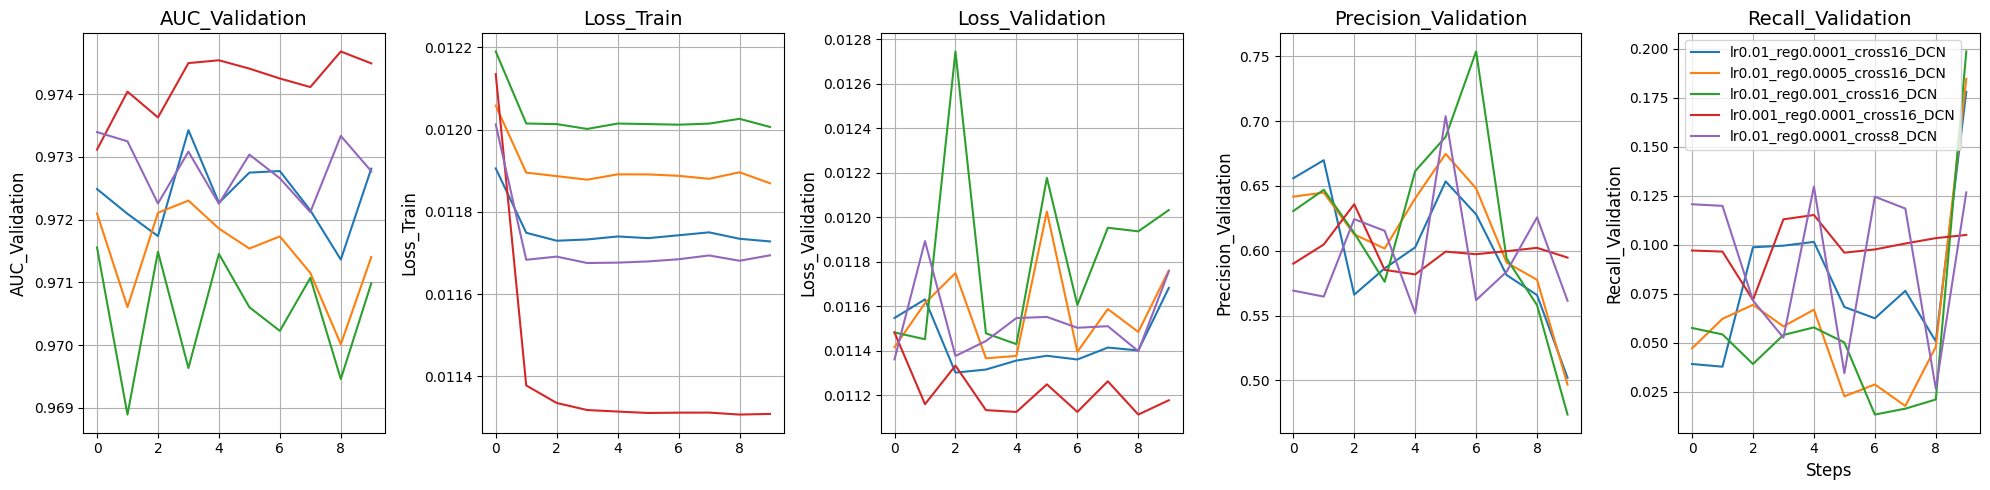

Experiment Name: lr0.01_reg0.0001_cross16_DCN
  Loss_Train: 0.0118
  Loss_Validation: 0.0114
  AUC_Validation: 0.9724
  Precision_Validation: 0.6012
  Recall_Validation: 0.0813
Experiment Name: lr0.01_reg0.0005_cross16_DCN
  Loss_Train: 0.0119
  Loss_Validation: 0.0116
  AUC_Validation: 0.9715
  Precision_Validation: 0.6129
  Recall_Validation: 0.0606
Experiment Name: lr0.01_reg0.001_cross16_DCN
  Loss_Train: 0.0120
  Loss_Validation: 0.0118
  AUC_Validation: 0.9705
  Precision_Validation: 0.6196
  Recall_Validation: 0.0563
Experiment Name: lr0.001_reg0.0001_cross16_DCN
  Loss_Train: 0.0114
  Loss_Validation: 0.0112
  AUC_Validation: 0.9742
  Precision_Validation: 0.5991
  Recall_Validation: 0.0996
Experiment Name: lr0.01_reg0.0001_cross8_DCN
  Loss_Train: 0.0117
  Loss_Validation: 0.0115
  AUC_Validation: 0.9728
  Precision_Validation: 0.5962
  Recall_Validation: 0.0925


In [13]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def extract_relevant_name(exp_name):
    """Extract the relevant part of the experiment name starting from 'lr'."""
    parts = exp_name.split('_')
    for i, part in enumerate(parts):
        if part.startswith("lr"):
            return '_'.join(parts[i:])  # Join everything from 'lr' onwards
    return exp_name  # Fallback to the full name if 'lr' is not found

def extract_all_metrics(base_dir, flag):
    # Dictionary to hold all metrics for all experiments
    all_metrics = {}

    # Get all experiment directories
    experiment_dirs = [os.path.join(base_dir, exp) for exp in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, exp))]

    for exp_dir in experiment_dirs:
        # Find the event file in the directory
        event_file = glob.glob(os.path.join(exp_dir, flag, "events.out.tfevents.*"))
        if event_file:
            ev = event_accumulator.EventAccumulator(event_file[0])
            ev.Reload()

            # Extract the relevant experiment name
            exp_name = os.path.basename(exp_dir)
            relevant_name = extract_relevant_name(exp_name)

            # Initialize a dictionary to hold metrics for the current experiment
            experiment_metrics = {}

            # Iterate over all scalar tags
            for scalar_tag in ev.Tags().get("scalars", []):
                scalar_data = ev.Scalars(scalar_tag)

                # Extract step and value for each tag
                steps = [event.step for event in scalar_data]
                values = [event.value for event in scalar_data]

                # Store in the experiment's dictionary
                experiment_metrics[scalar_tag] = {"steps": steps, "values": values}

            # Add the experiment's metrics to the main dictionary
            all_metrics[relevant_name] = experiment_metrics
        else:
            print(f"No event file found in {exp_dir}")

    return all_metrics

def organize_for_plotting(all_metrics):
    """Organize metrics for plotting."""
    plot_data = {}
    for exp_name, metrics in all_metrics.items():
        plot_data[exp_name] = {}
        for metric_name, data in metrics.items():
            steps = data["steps"]
            values = data["values"]
            plot_data[exp_name][metric_name] = {"steps": steps, "values": values}
    return plot_data

def plot_metrics(plot_data):
    """Generate a single figure with subplots for each metric, showing all experiments."""
    # Find all unique metric names across all experiments
    all_metric_names = set()
    for exp_name, metrics in plot_data.items():
        all_metric_names.update(metrics.keys())

    all_metric_names = sorted(all_metric_names)
    num_metrics = len(all_metric_names)

    # Create a single figure with subplots
    fig, axes = plt.subplots(nrows=1 , ncols=num_metrics, figsize=(20, 5), sharex=True)

    # If there's only one metric, axes won't be a list
    if num_metrics == 1:
        axes = [axes]

    for i, metric_name in enumerate(all_metric_names):
        ax = axes[i]
        for exp_name, metrics in plot_data.items():
            if metric_name in metrics:
                data = metrics[metric_name]
                steps = data["steps"]
                values = data["values"]
                ax.plot(steps, values, label=exp_name)
                

        ax.set_title(f"{metric_name}", fontsize=14)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.grid()
    ax.legend(loc="best", fontsize=10)

    # Add shared X-axis label
    plt.xlabel("Steps", fontsize=12)
    plt.tight_layout()
    plt.show()

# Print the extracted names and metrics
# for exp_name, metrics in all_metrics.items():
#     print(f"Experiment Name: {exp_name}")
#     print(f"Metrics: {list(metrics.keys())}")
#     print()


base_dir = "F:/Bytedance/ByteDance_CTR/Results/DCN/DCN_event"
flag = "treatment"
all_metrics = extract_all_metrics(base_dir, flag)
plot_data = organize_for_plotting(all_metrics)

# print(plot_data)

plot_metrics(plot_data)

# print average metrics for differnt experiments
for exp_name, metrics in all_metrics.items():
    print(f"Experiment Name: {exp_name}")
    for metric_name, data in metrics.items():
        values = data["values"]
        avg_value = np.mean(values)
        print(f"  {metric_name}: {avg_value:.4f}")